In [1]:
import numpy as np
import helpers
import implementations

# Defining functions

In [2]:
def accuracy(y, tx, w):
    """Return the accuracy of the model."""
    pred    = np.where(tx.dot(w) > 0, 1, 0)
    correct = np.sum(pred == y)
    return correct / len(y)

The `build_test_train` function split the dataset into training/testing set in oder to perform cross validation tests.

In [3]:
def build_test_train(y, tx, ratio=0.9, seed=1):
    """Split the dataset (y, tx) into training/testing set according to the split ratio"""
    # performing permutation before splitting the dataset
    np.random.seed(seed)
    indices = np.random.permutation(len(y))

    # defining indices for y, tx
    delimiter_indice = int(ratio * len(y))
    te_indices = indices[delimiter_indice:]
    tr_indices = indices[:delimiter_indice]

    # creating the train/test sets
    y_te = y[te_indices]
    y_tr = y[tr_indices]
    tx_te = tx[te_indices]
    tx_tr = tx[tr_indices]
    return y_te, y_tr, tx_te, tx_tr

# Loading data

In [4]:
yb,      input_data,      ids      = helpers.load_csv_data("./data/train.csv")
yb_test, input_data_test, ids_test = helpers.load_csv_data("./data/test.csv")
# creating classification vector y that fits for logistic regression
y  = np.where(yb > 0, 1, 0)

# Finding the best model for the classification

### logistic regression and least squares
At first, we have to normalize and format the data.

In [9]:
# normalization of the data
x = implementations.z_normalize(input_data)
tx = np.append(np.ones(len(x)).reshape(-1,1), x, axis=1)

Then, we train our two models.

In [22]:
w_log_reg, loss = implementation.logistic_regression(y, tx, initial_w=np.zeros(tx.shape[1]), max_iters=2000, gamma=0.000003)
w_ls, loss      = implementation.least_squares(yb, tx)

We can see that logistic regression appears to achieve better accuracy.

In [23]:
print('Accuracy for logistic regression : ',accuracy(y, tx, w_log_reg))
print('Accuracy for least squares       : ',accuracy(y, tx, w_ls))

Accuracy for logistic regression :  0.75024
Accuracy for least squares       :  0.744972


#### Testing overfitting
We separate our dataset in the training set and the test set.

First, we train the data on the training set and then we test our model on the test set

In [24]:
y_te,  y_tr,  tx_te, tx_tr = build_test_train(y, tx)

In [25]:
w_log_reg, loss = implementation.logistic_regression(y_tr, tx_tr, initial_w=np.zeros(tx_tr.shape[1]), max_iters=2000, gamma=0.000003)

In [26]:
print('Accuracy for training set : ',accuracy(y_tr, tx_tr, w_log_reg))
print('Accuracy for testing set  : ',accuracy(y_te, tx_te, w_log_reg))

Accuracy for training set :  0.7504977777777778
Accuracy for testing set  :  0.74872


We can see that the accuracy for the training and testing set is really close.
It means that our model does not over fit too much and adding a regulator term would not yield significant improvements on the test set.

When taking a look at the leaderboard we notice that these results seem not good enough. Maybe our model is too simple as many teams can achieve over 0.8 accuracy.

### Using interaction of predictors

One good way of augmenting complexity of the model is to add interaction predictors.
Let's $p_{ij}$ be the interaction predictor mixing feature $f_i$ and feature $f_j$.
Then, $p_{ij} = f_i \cdot f_j$

The function `build_interactio_tx` will return an array `tx` with the initial features and the interaction predictors.

In [10]:
def build_interaction_tx(input_data, normalisation_function):
    """return the input vector tx with interaction terms"""
    # first normalizing the input data
    input_data = normalisation_function(input_data)

    n_features = input_data.shape[1]
    n_interacted_features = int((n_features-1) * n_features / 2)

    # creating the future output array
    x = np.empty((n_features + n_interacted_features, len(input_data)))
    x[:n_features] = input_data.T

    # adding interaction predictors to the output array
    index = n_features
    for i in range(n_features):
        for j in range(i):
            x[index] = x[i] * x[j]
            index = index + 1

    # normalizing the data and adding the bias term
    x = normalisation_function(x.T)
    tx = np.append(np.ones(len(x)).reshape(-1,1), x, axis=1)

    return tx

At first, we create interaction our new input with interaction terms.
Then, we split in train/test set.

In [11]:
tx = build_interaction_tx(input_data, implementation.z_normalize)
y_te, y_tr, tx_te, tx_tr = build_test_train(y, tx)
yb_te, yb_tr, tx_te, tx_tr = build_test_train(yb, tx)

NameError: name 'implementation' is not defined

We now train our two models.

In [29]:
w_log_reg, loss = implementation.logistic_regression(y_tr, tx_tr, initial_w=np.zeros(tx.shape[1]), max_iters=8000, gamma=0.0000005)
w_ls,      loss = implementation.least_squares(yb_tr, tx_tr)

In [30]:
print('Least squares')
print('Accuracy for training set : ',accuracy(y_tr, tx_tr, w_ls))
print('Accuracy for testing set  : ',accuracy(y_te, tx_te, w_ls))
print('Logistic regression')
print('Accuracy for training set : ',accuracy(y_tr, tx_tr, w_log_reg))
print('Accuracy for testing set  : ',accuracy(y_te, tx_te, w_log_reg))

Least squares
Accuracy for training set :  0.7910755555555555
Accuracy for testing set  :  0.7894
Logistic regression
Accuracy for training set :  0.8161022222222222
Accuracy for testing set  :  0.81424


We can see that Logistic regression achieve slightly better results than the least squares.
Moreover, this model is not victim to over fitting as the accuracy for the training set and testing set are really close.

# Taining the best model

The best model we found is the logistic regression on interaction terms. So we will train this model on the entire dataset.

In [23]:
tx = build_interaction_tx(input_data, implementations.z_normalize)

In [32]:
w_best, loss = implementation.logistic_regression(y, tx, initial_w=np.zeros(tx.shape[1]), max_iters=8000, gamma=0.0000005)

Now predicting output for the testing set.

In [33]:
tx_test = build_interaction_tx(input_data_test, implementation.z_normalize)

In [34]:
y_pred = np.where(tx_test.dot(w_best) > 0, 1, -1)

In [35]:
name = 'submission2'
helpers.create_csv_submission(ids_test, y_pred, name)

# Testing learnig rate

In [60]:
def GD(y, tx, initial_w, max_iters, gamma, gradient_func, loss_func):
    """The general Gradient Descent (GD) algorithm."""
    w = initial_w
    acc = np.empty(max_iters)
    for i in range(max_iters):

        grad = gradient_func(y, tx, w)
        w = w - gamma * grad
        acc[i] = accuracy(y, tx, w)
        #print(accuracy(y, tx, w))

    return w, acc

def logistic_regression(y, tx, initial_w, max_iters, gamma):
    w, loss = GD(y, tx, initial_w, max_iters, gamma, implementations.logistic_gradient, implementations.logistic_loss)
    return w, loss

In [51]:
w, acc = logistic_regression(y, tx, initial_w=np.zeros(tx.shape[1]), max_iters=10000, gamma=0.1)

0.630444
0.640624
0.662684
0.667548
0.671036
0.67536
0.680692
0.685948
0.690676
0.694832


In [26]:
import matplotlib.pyplot as plt

In [38]:
for i in range(len(acc)):
    if i%1000 == 0:
        print(acc[i])

print(acc[-1])

0.630444
0.806424
0.811296
0.813068
0.814164
0.81464
0.815012
0.815308
0.815456
0.815656
0.815812
0.815848
0.815888


In [79]:
gammas = np.logspace(-3, 0, num=50)
res = np.empty(len(gammas))
for i, gamma in enumerate(gammas):
    w, acc = logistic_regression(y, tx, initial_w=np.zeros(tx.shape[1]), max_iters=10, gamma=gamma)
    res[i] = acc[-1]

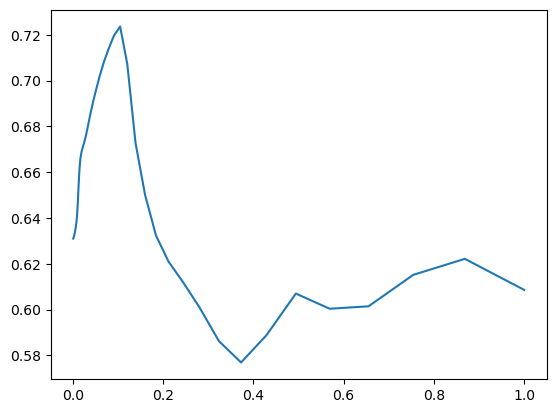

In [80]:
plt.plot(gammas, res)

In [81]:
np.max(res)

0.72366

In [82]:
res

array([0.63102 , 0.631096, 0.631232, 0.631364, 0.631508, 0.631736,
       0.631976, 0.632136, 0.632524, 0.632856, 0.63322 , 0.633892,
       0.634792, 0.635704, 0.636904, 0.638832, 0.641588, 0.646336,
       0.653504, 0.660816, 0.665968, 0.668908, 0.671096, 0.673256,
       0.676372, 0.680584, 0.685592, 0.690796, 0.696216, 0.70206 ,
       0.70804 , 0.71378 , 0.719628, 0.72366 , 0.707224, 0.672804,
       0.650212, 0.632396, 0.620968, 0.611992, 0.600812, 0.586252,
       0.576916, 0.588868, 0.607016, 0.600388, 0.601452, 0.615188,
       0.622176, 0.60862 ])

In [83]:
gammas[33]

0.10481131341546852